# Pytorch demo of the Neural Tangent Ensembles (NTE) method

# Functions

In [7]:
import torch
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import copy
from tqdm import tqdm

from scipy.stats import norm


In [8]:
## Create the problem

def shuffled_MNIST(batch_size, dataset_folder='./data'):
    """Create a MNIST dataset in which pixels are shuffled, and return the test and train dataloaders.
    Uses a new random seed every time it's called.

    Arguments:    batch_size: tha batch size
                  dataself_folder: path to the mnist dataset, or where it should go once downloaded

    """

    kwargs = {'num_workers': 0, 'pin_memory': True}

    permute_mask = torch.randperm(784)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.view(784)[permute_mask])
        ])

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(dataset_folder, train=True, download=True,
                       transform=transform),
        batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(dataset_folder, train=False, transform=transform),
        batch_size=batch_size, shuffle=False, drop_last=True, **kwargs)

    return (train_loader, test_loader)

train_loader, test_loader = shuffled_MNIST(128)
for a,b in train_loader:
  print(a.shape, b.shape)
  break

torch.Size([128, 784]) torch.Size([128])


In [9]:


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, num_features, n_layers=2):
        super(MLP, self).__init__()
        self.num_features = num_features

        # Initialize the fixed random weights for the first layer
        self.first_layer_weights = nn.Linear(input_dim, num_features)

        # mid layers
        self.mid_layers = nn.ModuleList([nn.Linear(num_features, num_features) for _ in range(n_layers-2)])

        # The second layer is learnable
        self.linear = nn.Linear(num_features, output_dim)

        self.linear.bias.data.fill_(0)
 

    def forward(self, x, ):
        x = self.first_layer_weights(x)
        x = torch.relu(x)

        for layer in self.mid_layers:
            x = layer(x)
            x = torch.relu(x)
        
        output = self.linear(x)

        return output


def count_zero_edges(model):
    zero_edges = 0
    total_edges = 0
    for p in model.parameters():
        zero_edges += (p == 0).sum().item()
        total_edges += p.numel()
    return zero_edges, total_edges


def number_equal_edges(model_params, init_model_params):
    edges = 0
    for p, p_2 in zip(model_params, init_model_params):
        edges += (p==p_2).sum().item()
    return edges

def count_total_edges(model):
    edges = 0
    for p in model.parameters():
        edges += p.numel()
    return edges

def plot_posteriors(log_posteriors):
    fig, axs = plt.subplots(1, 4, figsize=(15, 3))
    for i, p in enumerate(log_posteriors.items()):
        axs[i].hist(p[1].flatten().cpu().numpy(), bins=100, label=p[0])
        axs[i].set_yscale('log')
        axs[i].set_title(p[0])
    plt.show()

In [10]:
       
def train_and_evaluate(model, train_loader, test_loaders, optimizer, num_epochs, device, eval_interval, test_batches=10,log_edges=False):
    model.to(device)  # Move the model to the appropriate device
    all_accuracies = {i: [] for i in range(len(test_loaders))}  # Dictionary to store accuracies
    total_edges = count_total_edges(model)
    batch_count = 0  # Counter for tracking the number of batches
    accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as t:
            for data, target in t:
                data, target = data.to(device), target.to(device)  # Move data to the appropriate device
                optimizer.zero_grad()
                output = model(data)
                loss = nn.CrossEntropyLoss()(output, target)
                loss.backward()
                optimizer.step()
                batch_count += 1

                if batch_count % eval_interval == 0:
                    model.eval()
                    with torch.no_grad():
                        for i, test_loader in enumerate(test_loaders):
                            correct = 0
                            total = 0
                            j = 0
                            for data, target in test_loader:
                                data, target = data.to(device), target.to(device)
                                output = model(data)
                                _, predicted = torch.max(output.data, 1)
                                total += target.size(0)
                                correct += (predicted == target).sum().item()
                                j += 1
                                if j >= test_batches:
                                    break
                            accuracy = 100 * correct / total
                            all_accuracies[i].append(accuracy)
                    model.train()

                n_zero_edges = number_equal_edges(model.parameters(), optimizer.init_param_groups_fn()[0]['params']) if log_edges else 0
                t.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f} - Restored edges: {n_zero_edges} / {total_edges} - Test accuracy: {accuracy:.2f}%")

    return all_accuracies

def plot_accuracies(all_accuracies, num_epochs, num_rounds, eval_interval, train_loader):
    offset = len(train_loader) // eval_interval * num_epochs

    plt.figure(figsize=(10, 6))
    for i, accs in enumerate(all_accuracies):
        accs = np.concatenate([[0]*(i*offset+1)]+[a.get(i,[]) for a in all_accuracies])

        plt.plot(accs, label=f'Task {i+1}')
        plt.vlines(range(0,num_rounds*offset, offset), 0, 100, linestyles=":", colors="r")
    plt.xlabel('Epoch')
    plt.ylabel('Test accuracy on Task (%)')
    plt.title('Accuracy on All Tasks During Continual Learning')
    plt.legend()
    plt.show()

In [11]:


def reinitialize_with_sign(model, magnitude=.001):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            with torch.no_grad():
                weight_sign = module.weight.sign() * magnitude
                module.weight.copy_(weight_sign)

def perturb_model(model, noise_scale):
    for p in model.parameters():
        p.data += torch.randn_like(p.data) * noise_scale
    return model

def perturb_model_bernoulli(model, noise_scale):
    for p in model.parameters():
        p.data += torch.sign(torch.randn_like(p.data)) * noise_scale
    return model
    

    


# Tests


## Benchmark: SGD on a 2LMLP

Epoch 1/2 - Loss: 0.1158 - Restored edges: 0 / 79500010 - Test accuracy: 92.58%: 100%|██████████| 468/468 [00:14<00:00, 32.33it/s]
Epoch 2/2 - Loss: 0.2135 - Restored edges: 0 / 79500010 - Test accuracy: 94.22%: 100%|██████████| 468/468 [00:11<00:00, 40.21it/s]
Epoch 1/2 - Loss: 0.1035 - Restored edges: 0 / 79500010 - Test accuracy: 93.05%: 100%|██████████| 468/468 [00:14<00:00, 31.86it/s]
Epoch 2/2 - Loss: 0.1013 - Restored edges: 0 / 79500010 - Test accuracy: 93.98%: 100%|██████████| 468/468 [00:17<00:00, 26.78it/s]
Epoch 1/2 - Loss: 0.1411 - Restored edges: 0 / 79500010 - Test accuracy: 92.89%: 100%|██████████| 468/468 [00:20<00:00, 22.65it/s]
Epoch 2/2 - Loss: 0.1453 - Restored edges: 0 / 79500010 - Test accuracy: 93.44%: 100%|██████████| 468/468 [00:21<00:00, 22.00it/s]
Epoch 1/2 - Loss: 0.3661 - Restored edges: 0 / 79500010 - Test accuracy: 92.50%: 100%|██████████| 468/468 [00:24<00:00, 19.14it/s]
Epoch 2/2 - Loss: 0.0987 - Restored edges: 0 / 79500010 - Test accuracy: 94.45%: 10

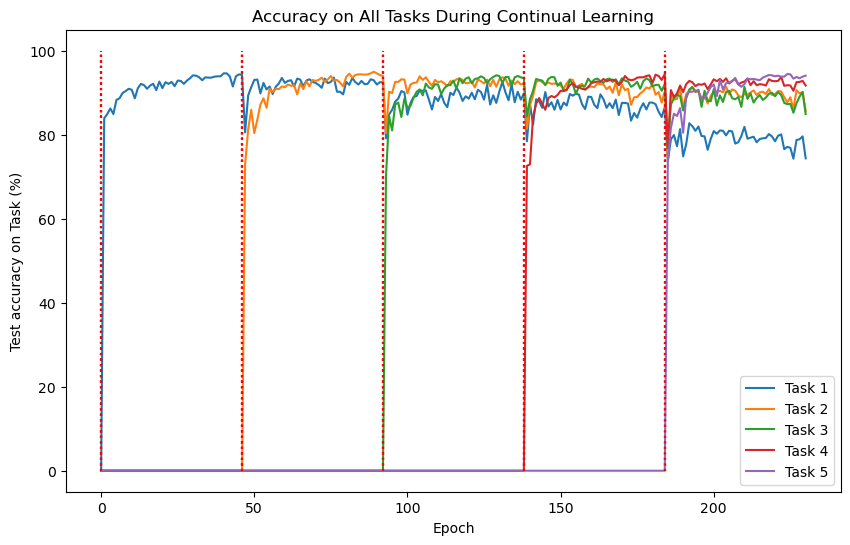

In [12]:

num_rounds = 5  # Number of datasets to create and train on
num_epochs = 2  # Number of epochs to train on each dataset
all_accuracies = []
zero_edges = []

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_dim=784, output_dim=10, num_features=100000, n_layers=2)  # Initialize the model
optimizer = optim.SGD(model.parameters(),0.01, weight_decay=0)

eval_interval = 20
for round in range(num_rounds):
    train_loader, test_loader = shuffled_MNIST(128)  # Create new shuffled dataset

    # Update all test loaders to include the new test set
    if round == 0:
        all_test_loaders = [test_loader]
        # start on a good foot
    else:
        all_test_loaders.append(test_loader)

    # Train the model and evaluate on all datasets
    accuracies = train_and_evaluate(model, train_loader, all_test_loaders, optimizer, num_epochs, device, eval_interval, test_batches=10,log_edges=False)
    all_accuracies.append(accuracies)

plot_accuracies(all_accuracies, num_epochs, num_rounds, eval_interval, train_loader)

Text(0.5, 1.0, 'Noise level 0.001')

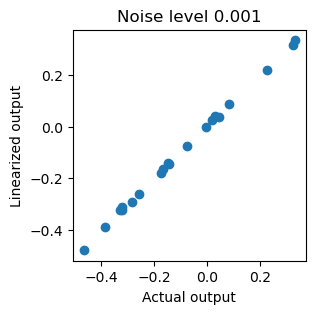

In [13]:


def linearized_model_forward(model, init_model, x):
    """Return the output of the linearized model around the initialization, i.e., the NTK approximation."""
    # Compute the output of the model at the initialization
    init_output = init_model(x)

    # Initialize the linearized output with the detached initial output
    linearized_output = init_output.detach().clone()

    # Iterate over each example and dimension. Needed due to autograd limitations. 
    for i in range(x.size(0)):
        for j in range(init_output.size(1)):
            # Compute the gradient of the model output with respect to the parameters for this example
            init_grads_example = torch.autograd.grad(init_output[i,j], init_model.parameters(), retain_graph=True)

            # Update the linearized output for each parameter and each output dimension
            for param, init_param, grad in zip(model.parameters(), init_model.parameters(), init_grads_example):
                delta_param = (param - init_param.detach())
                linearized_output[i, j] += torch.sum(grad.detach() * delta_param)
    return linearized_output


s = 1e-3
model = MLP(input_dim=784, output_dim=10, num_features=1_000_00, n_layers=2)  # Initialize the model
model_perturbed = perturb_model_bernoulli(copy.deepcopy(model), s)
x = torch.randn(2,784)
output = linearized_model_forward(model_perturbed, model, x)

plt.figure(figsize=(3,3))
plt.scatter(output.detach(), model_perturbed(x).detach())
plt.xlabel("Actual output")
plt.ylabel("Linearized output")
plt.title(f"Noise level {s}")

In [14]:

def train_and_evaluate_NTKBayes(model, log_posterior_buffer, train_loader, test_loaders, num_epochs, device, init_model=None, which_grads='current', max_param_size=1,
                    temperature=1, test_batches = 10):
    """
    Implements a training loop the data and runs for a specified number of epochs. 
    In addition, it evaluates the model on a list of test sets after each epoch, maybe corresponding to different tasks.

    Rather than provide a separate Optimizer, here I run everything explicitly in the training loop. 
    The reason for this is that I need per-example gradients, and I'm using vmap to compute them.

    Parameters:
    - model (torch.nn.Module): The neural network model to be trained and evaluated.
    - log_posterior_buffer (dict): A dictionary of tensors to store the log posterior of each parameter. 
                                   This is not strictly necessary, since the log posterior is simply the log of the weight.
                                   But if the weights are very small, you might get numerical instability.
                                   This might not be a problem in practice but I wanted to be safe.
    - train_loader (torch.utils.data.DataLoader): The DataLoader for training data.
    - test_loaders (list[torch.utils.data.DataLoader]): A list of DataLoaders for evaluation data.
    - num_epochs (int): The number of epochs to train the model.
    - device (torch.device): The device to run the training on (e.g., 'cuda' or 'cpu').
    - init_model (torch.nn.Module): A full copy of the model at initialization. If None, assumes we're comparing to the null model.
    - which_grads (str): Which gradients to use for the NTK features. Options are 'current' or 'init'.
    - max_param_size (float): The maximum size of the parameters. This is used to cap the log posterior.
    - temperature (float): The INVERSE temperature for the data likelihood. Smaller is more stable.
    - test_batches (int): For speed, the number of batches to evaluate the model on each test set.

    Returns:
    - dict: A dictionary where each key is the index of the test loader in `test_loaders` and each value is a list of accuracies recorded at the end of each epoch.

    """
    all_accuracies = {i: [] for i in range(len(test_loaders))}  # Dictionary to store accuracies

    loss_fn = nn.CrossEntropyLoss()

    def compute_loss(params, buffers, sample, target):
        batch = sample.unsqueeze(0)
        targets = target.unsqueeze(0)

        predictions = torch.func.functional_call(model, (params, buffers), (batch,))
        loss = loss_fn(predictions, targets)
        return loss

    ft_compute_grad = torch.func.grad_and_value(compute_loss)
    ft_compute_sample_grad = torch.func.vmap(ft_compute_grad, in_dims=(None, None, 0, 0))
    ft_compute_losses = torch.func.vmap(compute_loss, in_dims=(None, None, 0, 0))

    if init_model is None:
        init_model_params = {name: 0 for name, p in model.named_parameters()}
        init_model_buffers = {name: 0 for name, p in model.named_buffers()}
    else:
        init_model_params = {k: v.detach() for k, v in init_model.named_parameters()}
        init_model_buffers = {k: v.detach() for k, v in init_model.named_buffers()}

    z = sum([(p-p_c).abs().sum() for ((_, p), (_, p_c)) in zip( model.named_parameters(), init_model_params.items())])
    print(f"z is {z.item()}")
    log_z = torch.log(z)

    batch_count = 0
    accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as t:
            for batch, (data, target) in enumerate(t):
                data, target = data.to(device), target.to(device)  # Move data to the appropriate device

                params = {k: v.detach() for k, v in model.named_parameters()}
                buffers = {k: v.detach() for k, v in model.named_buffers()}

                if which_grads == 'current':
                    per_example_grad_dict, losses = ft_compute_sample_grad( params, buffers, data, target)
                elif which_grads == 'init':
                    assert init_model is not None, "Cannot use init grads without an init model"
                    per_example_grad_dict, losses = ft_compute_sample_grad( init_model_params, init_model_buffers, data, target)

                with torch.no_grad():
                    for (name, d_p), (name2, p), (name3, p_c), (_,log_posterior) in zip(per_example_grad_dict.items(), 
                                                                                model.named_parameters(),
                                                                                init_model_params.items(),
                                                                                log_posteriors.items()):
                        if not p.requires_grad:
                            continue

                        if init_model is None:
                            # If init_params is None, use the current gradients divided by 2 for linearization
                            delta_p = p.data
                        else:
                            # Compute ∆W and use it as the weight for NTK features
                            delta_p = p.data - p_c.data

                        # store sign of weight
                        sign_delta_p = torch.sign(delta_p)

                        n_dims = len(delta_p.size())

                        arg = -sign_delta_p[None] * d_p * temperature
                        assert torch.all(arg+1 >= 0), f"Tried log(1+{torch.min(arg).item()}) for {name}. Decrease temperature."
                        data_log_likelihood = torch.log1p(arg)
                        data_log_likelihood = data_log_likelihood.sum(dim=0)
                    
                        # Update log(∆W) based on the gradient and temperature
                        log_posterior += data_log_likelihood

                    # Get the log partition function
                    log_z_prime = torch.logsumexp(torch.stack([torch.logsumexp(lp, dim=list(range(len(lp.size()))))
                                                             for (name, lp) in log_posteriors.items()]), dim=0)

                    # set parameters
                    for (name, log_posterior), (_, p), (_, p_c) in zip(log_posteriors.items(), model.named_parameters(), init_model_params.items()):
                        if not p.requires_grad:
                            continue
                        if init_model is None:
                            # If init_params is None, use the current gradients divided by 2 for linearization
                            delta_p = p.data
                        else:
                            # Compute ∆W and use it as the weight for NTK features
                            delta_p = p.data - p_c.data

                        log_posterior += log_z - log_z_prime
                        sign_delta_p = torch.sign(delta_p)

                        # Warn if any log_posterior is too small
                        if torch.any(log_posterior <= torch.finfo(log_posterior.dtype).min):
                            print(f"WARNING: {name} has reached the minimum value of {torch.finfo(log_posterior.dtype).min}. Consider decreasing the temperature.")

                        # Cap the log posterior to prevent going too far
                        log_posterior = torch.clamp(log_posterior, max=np.log(max_param_size))

                        # Update the parameter.
                        if init_model is None:
                            p.data = sign_delta_p * torch.exp(log_posterior)
                        else:
                            p.data = p_c.data + sign_delta_p * torch.exp(log_posterior)

                    if batch_count % eval_interval == 0:
                        model.eval()
                        for i, test_loader in enumerate(test_loaders):
                            correct = 0
                            total = 0
                            j = 0
                            for data, target in test_loader:
                                data, target = data.to(device), target.to(device)
                                output = model(data)
                                loss =  nn.CrossEntropyLoss()(output, target)
                                _, predicted = torch.max(output.data, 1)
                                total += target.size(0)
                                correct += (predicted == target).sum().item()
                                j += 1
                                if j >= test_batches:
                                    break
                            accuracy = 100 * correct / total
                            all_accuracies[i].append(accuracy)
                        model.train()

                    batch_count += 1

                t.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.mean().item():.4f}  - Test accuracy: {accuracy:.2f}%") #t.set_description
            
    with torch.no_grad():
        model.eval()
        for i, test_loader in enumerate(test_loaders):
            correct = 0
            total = 0
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss =  nn.CrossEntropyLoss()(output, target)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            accuracy = 100 * correct / total
            all_accuracies[i].append(accuracy)
            print(f"Task {i} Full test loss: {loss.mean().item():.4f}  - Test accuracy: {accuracy:.2f}%")
        model.train()
                
    return all_accuracies

def perturb_model(model, noise_scale):
    for p in model.parameters():
        p.data += torch.randn_like(p.data) * noise_scale
    return model

def perturb_model_bernoulli(model, noise_scale):
    for p in model.parameters():
        p.data += torch.sign(torch.randn_like(p.data)) * noise_scale
    return model

def perturb_model_normalized_vector(model, test=False):
    perturbations = [torch.randn_like(p.data) for p in model.parameters()]
    pert_norm = sum([(p).abs().sum() for p in perturbations]).item()
    perturbations = [p / pert_norm for p in perturbations]
    if test:
        print("L2", sum([torch.sum(p**2) for p in perturbations]).item())
        print("L1", sum([(p).abs().sum() for p in perturbations]).item())
    for p,pert in zip(model.parameters(), perturbations):
        p.data += pert
    return model
def divide_parameters(model, C):
    for param in model.parameters():
        param.data.div_(C)
    return model

z is 1403367.375


Epoch 1/2 - Loss: 0.1954  - Test accuracy: 95.31%: 100%|██████████| 1875/1875 [08:16<00:00,  3.78it/s]
Epoch 2/2 - Loss: 0.1078  - Test accuracy: 97.50%: 100%|██████████| 1875/1875 [07:27<00:00,  4.19it/s]


Task 0 Full test loss: 0.2168  - Test accuracy: 95.50%


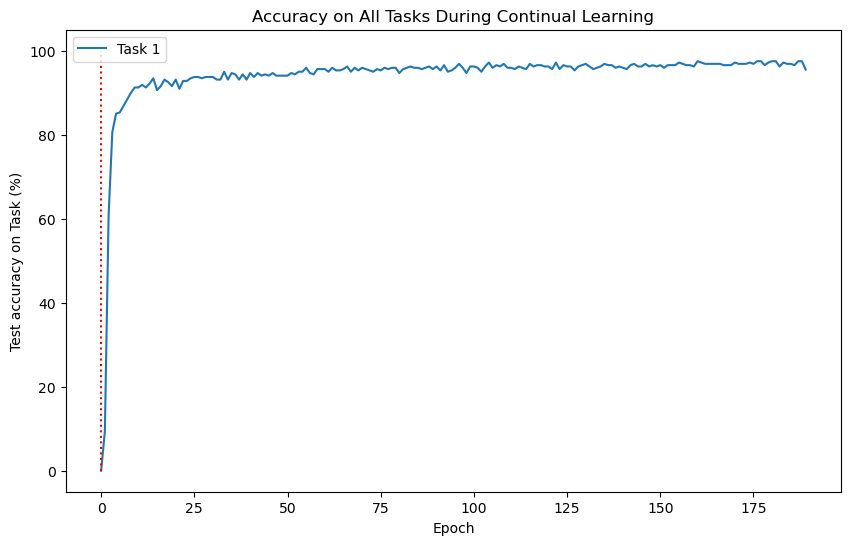

z is 792173.25


Epoch 1/2 - Loss: 0.0532  - Test accuracy: 97.19%: 100%|██████████| 1875/1875 [08:18<00:00,  3.76it/s]
Epoch 2/2 - Loss: 0.0460  - Test accuracy: 98.44%: 100%|██████████| 1875/1875 [07:33<00:00,  4.13it/s]


Task 0 Full test loss: 0.2218  - Test accuracy: 95.48%
Task 1 Full test loss: 0.1136  - Test accuracy: 96.90%


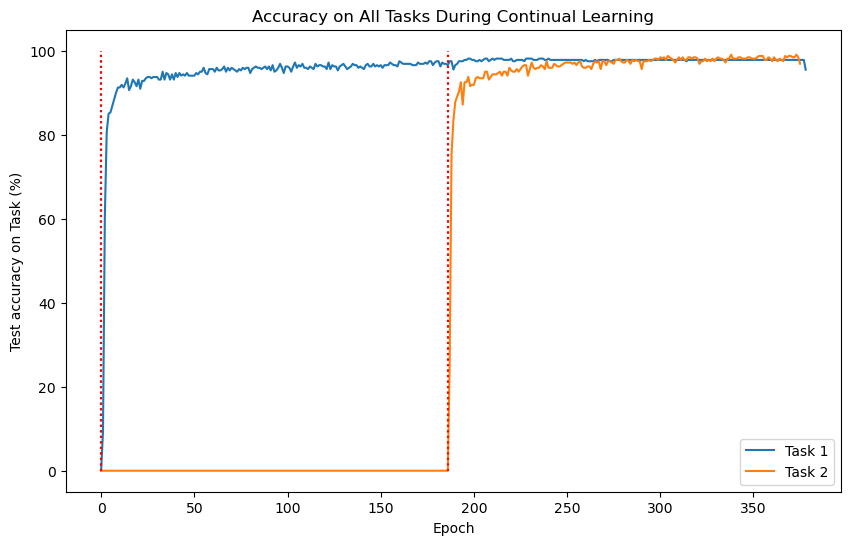

z is 732187.5625


Epoch 1/2 - Loss: 0.0515  - Test accuracy: 97.50%: 100%|██████████| 1875/1875 [08:09<00:00,  3.83it/s]
Epoch 2/2 - Loss: 0.0678  - Test accuracy: 97.19%:  31%|███       | 576/1875 [02:37<03:50,  5.64it/s]

In [15]:

num_rounds = 5  # Number of datasets to create and train on
num_epochs = 2  # Number of epochs to train on each dataset
all_accuracies = []

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device='cpu'    

model = MLP(input_dim=784, output_dim=10, num_features=100000, n_layers=2)  # Initialize the model
model = model.to(device)
log_posteriors = {name: torch.zeros_like(p) for name, p in model.named_parameters()}

eval_interval = 20

for r in range(num_rounds):
    train_loader, test_loader = shuffled_MNIST(32)  # Create new shuffled dataset
    # Update all test loaders to include the new test set
    if r == 0:
        all_test_loaders = [test_loader]
        # start on a good foot
    else:
        all_test_loaders.append(test_loader)

    # Train the model and evaluate on all datasets
    accuracies = train_and_evaluate_NTKBayes(model, log_posteriors, train_loader, all_test_loaders, num_epochs, device, 
                                            init_model=None, temperature=.1, max_param_size=.01,
                                            test_batches=10)

    # make a histogram of the log posteriors
    # plot_posteriors(log_posteriors)
    all_accuracies.append(accuracies)
    
    plot_accuracies(all_accuracies, num_epochs, r+1, eval_interval, train_loader)